# Clustering particles

In [1]:
# Libraries ----
import sys  # type: ignore
import imageio  # type: ignore
import warnings
import numpy as np  # type: ignore
import pandas as pd  # type: ignore

from tqdm import tqdm  # type: ignore

sys.path.append('../modules')
import track_particles as tp  # type: ignore
import plot_tracking as plt_tp  # type: ignore
import plot_clustering as plt_cp  # type: ignore
import clustering_particles as cp  # type: ignore

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

## Global variables

In [2]:
input_path = "../input_files"
output_path = "../output_files"
log_path = "../logs"
input_generation_date = "2025-02-18"

video_name = "3n_3m_0f_240214_4"
n_particles = int(video_name[0])
save_figures = True
save_tracking = True
x_bounds = [0, 1080]
y_bounds = [70, 1850]
x_zoom = [0, 1080]
y_zoom = [0, 1920]

## Setting video information

In [3]:
# Load the video
reader = imageio.get_reader("{}/{}.mp4".format(input_path, video_name), "ffmpeg")

# Check the number of frames
num_frames = reader.count_frames()
print("Total frames: {}".format(num_frames))

# Extract a frame to inspect the content
time = 0
frame = reader.get_data(time)
print("Frames resolution: {} x {}".format(frame.shape[0], frame.shape[1]))

Total frames: 162000
Frames resolution: 1080 x 1920


In [4]:
df_tracked = pd.concat([
    pd.read_csv("{}/tracked_{}_0.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_1.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_2.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_3.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_4.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_5.csv".format(output_path, video_name), low_memory=False)#,
    # pd.read_csv("{}/tracked_{}_6.csv".format(output_path, video_name), low_memory=False),
    #pd.read_csv("{}/tracked_{}_7.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_8.csv".format(output_path, video_name), low_memory=False)
]).sort_values(["id", "time"])

In [5]:
if "coords_x" in df_tracked.columns:
    df_tracked["coords_x"] = df_tracked["coords_x"].apply(lambda x: np.fromstring(x, sep=" "))
    df_tracked["coords_y"] = df_tracked["coords_y"].apply(lambda x: np.fromstring(x, sep=" "))
df_tracked.sort_values(["time", "id"]).head(2 * n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
0,0,0,71.296658,43.892545,71.351378,43.811084,NaN,71.296658,43.892545,NaN,71.296658,43.892545,0.542224,1945.0,101.266616,32.664783,0.946548,7
1,1,0,1128.355016,135.134225,1129.559456,135.749677,NaN,1128.355016,135.134225,NaN,1128.355016,135.134225,1.339620,18402.0,261.256200,98.072387,0.926868,7
2,2,0,71.180153,236.658206,71.589759,237.546302,0.0,91.000000,168.000000,0.270588,85.000000,172.000000,-0.287622,5240.0,140.177830,50.621343,0.932518,7
3,3,0,141.091814,444.704373,142.252499,446.915884,NaN,141.091814,444.704373,NaN,141.091814,444.704373,-0.349721,7134.0,164.611834,61.709658,0.927073,7
4,4,0,109.078244,566.100668,109.691980,565.936079,0.0,99.000000,454.000000,0.505882,97.000000,470.000000,-0.105940,2096.0,104.662453,64.092545,0.790568,7
5,5,0,1587.366647,1047.849108,1586.300554,1048.205363,NaN,1587.366647,1047.849108,NaN,1587.366647,1047.849108,-1.282736,5103.0,234.433755,75.698537,0.946433,7


In [6]:
# Manual Setup for time = 0
tracking_0 = df_tracked[df_tracked["time"] == 0]
cols = ["id", "time", "id_count", "position_x", "position_y", "orientation"]
print("Initial tracking at time 0:\n", tracking_0[cols])

if tracking_0.shape[0] != n_particles:
    # Manual fitting of initial time tracking
    tracking_0 = tracking_0.drop_duplicates(subset=["id"], keep="first")
    tracking_0 = tracking_0[tracking_0["id"].isin([1, 2, 3])]
    tracking_0["id"] = np.arange(n_particles)
    tracking_0["orientation"] = np.array([
        tracking_0["orientation"].values[0],
        -tracking_0["orientation"].values[1],
        tracking_0["orientation"].values[2]
    ])

    # Replace the manual setting
    df_tracked = pd.concat([
        tracking_0,
        df_tracked[df_tracked["time"] != 0]
    ]).sort_values(["id", "time"])

df_tracked.sort_values(["time", "id"]).head(2 * n_particles + 1)

Initial tracking at time 0:
    id  time  id_count   position_x   position_y  orientation
0   0     0         7    71.296658    43.892545     0.542224
1   1     0         7  1128.355016   135.134225     1.339620
2   2     0         7    71.180153   236.658206    -0.287622
3   3     0         7   141.091814   444.704373    -0.349721
4   4     0         7   109.078244   566.100668    -0.105940
5   5     0         7  1587.366647  1047.849108    -1.282736
6   6     0         7  1041.735918  1048.547382    -1.482221


,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
1,0,0,1128.355016,135.134225,1129.559456,135.749677,NaN,1128.355016,135.134225,NaN,1128.355016,135.134225,1.339620,18402.0,261.256200,98.072387,0.926868,7
2,1,0,71.180153,236.658206,71.589759,237.546302,0.0,91.000000,168.000000,0.270588,85.000000,172.000000,0.287622,5240.0,140.177830,50.621343,0.932518,7
3,2,0,141.091814,444.704373,142.252499,446.915884,NaN,141.091814,444.704373,NaN,141.091814,444.704373,-0.349721,7134.0,164.611834,61.709658,0.927073,7
7,0,3,71.153103,43.650051,71.214526,43.578712,NaN,71.153103,43.650051,NaN,71.153103,43.650051,0.547175,1966.0,102.250605,32.892581,0.946846,7
8,1,3,1129.018491,135.522993,1130.406676,136.268184,NaN,1129.018491,135.522993,NaN,1129.018491,135.522993,1.338298,18658.0,261.552924,98.271022,0.926733,7
9,2,3,71.136320,236.858151,71.556399,237.765684,0.0,81.000000,169.000000,0.262745,90.000000,172.000000,-0.286899,5245.0,139.971936,50.771906,0.931895,7
10,3,3,141.033872,444.308222,142.180944,446.076880,NaN,141.033872,444.308222,NaN,141.033872,444.308222,-0.361507,7115.0,163.056815,60.909388,0.927611,7


In [7]:
df_tracked.sort_values(["time", "id"]).tail(5)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
30799,2,161997,700.904265,150.774829,703.841041,150.160317,0.0,660.000000,76.000000,0.584314,675.000000,121.000000,0.955664,13412.0,203.040299,98.468296,0.874531,7
30800,3,161997,325.491840,272.210869,328.278135,270.483591,NaN,325.491840,272.210869,NaN,325.491840,272.210869,-0.856816,12439.0,236.488906,75.248830,0.948026,7
30801,4,161997,1715.100295,584.091445,1714.227182,585.119310,0.0,1719.000000,519.000000,0.211765,1728.000000,523.000000,-0.138388,5763.0,137.470935,62.237721,0.891646,7
30802,5,161997,1689.133706,718.062339,1687.266647,718.480086,NaN,1689.133706,718.062339,NaN,1689.133706,718.062339,0.113598,2326.0,116.296557,65.044499,0.828966,7
30803,6,161997,1583.967388,1048.498689,1582.555765,1048.913921,NaN,1583.967388,1048.498689,NaN,1583.967388,1048.498689,-1.310168,6102.0,253.244622,76.858724,0.952833,7


## Velocities distribution in each frame

In [8]:
omega_threshold = np.pi / 2 # Angular velocity per frame
velocity_threshold = 94.0 # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi)

# Compute differences for each id
df_tracked["delta_time"] = df_tracked.groupby(["id"])["time"].diff()
df_tracked["velocity_x"] = df_tracked.groupby(["id"])["position_x"].diff()
df_tracked["velocity_y"] = df_tracked.groupby(["id"])["position_y"].diff()
df_tracked["velocity_orientation"] = df_tracked.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_tracked["velocity_x"] = df_tracked["velocity_x"] / df_tracked["delta_time"]
df_tracked["velocity_y"] = df_tracked["velocity_y"] / df_tracked["delta_time"]
df_tracked["velocity_orientation"] = df_tracked["velocity_orientation"] / df_tracked["delta_time"]

# Filter short jumps (highest velocities are False)
df_tracked["mask_x"] = np.where(np.abs(df_tracked["velocity_x"]) <= velocity_threshold, True, False)
df_tracked["mask_y"] = np.where(np.abs(df_tracked["velocity_y"]) <= velocity_threshold, True, False)
df_tracked["mask_orientation"] = np.where(np.abs(df_tracked["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 94.0 
	- Angle: 90.0


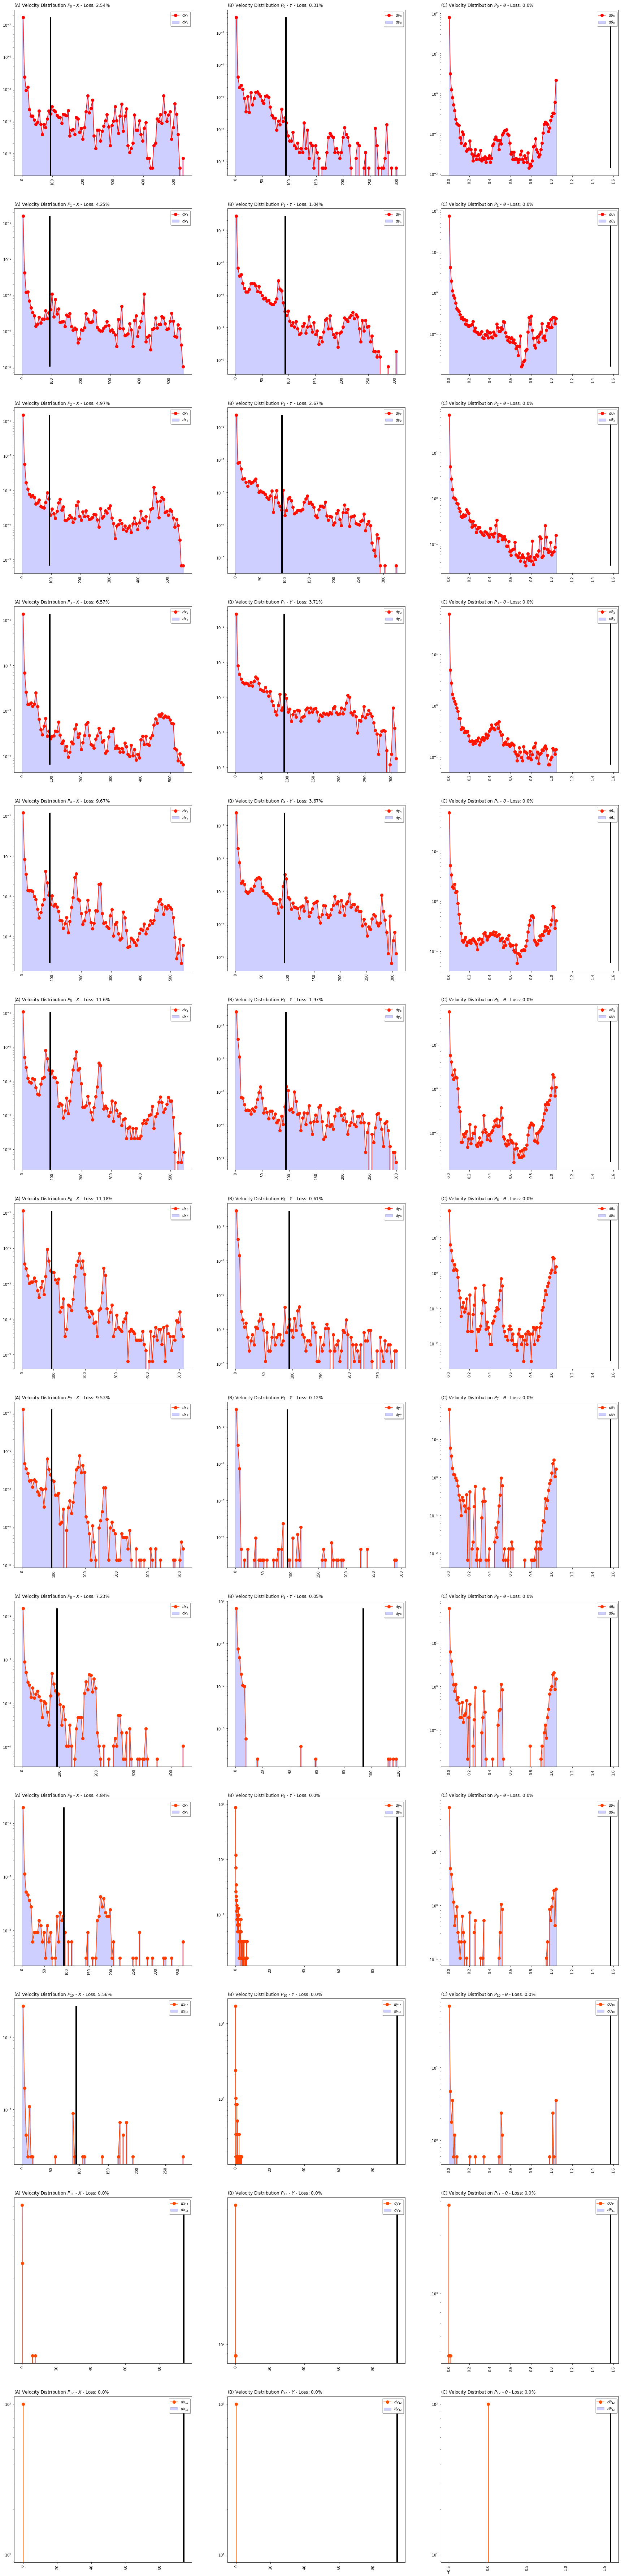

In [9]:
bins = 100
width = 10
fancy_legend = True

plt_cp.plot_velocities_distribution(
    df_tracked=df_tracked,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [10]:
df_tracked[["id_count"]].value_counts(dropna=False, sort=False, normalize=False).reset_index().sort_values("id_count")

,id_count,count
0,3,615
1,4,7924
2,5,35410
3,6,86694
4,7,110519
5,8,80664
6,9,31509
7,10,7480
8,11,1650
9,12,120


## Clustering frames

In [11]:
# id_count = df_tracked["id_count"].max()
type = "local equalized"
clip_limit = 0.05
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = 100 # Velocity per frame limited with half average size of particle
compare_bounds = False
similarity_threshold = 0.85

print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")
# ids = df_tracked[df_tracked["id_count"] != n_particles]["id_count"].unique()
# ids = sorted(np.sort(ids), key=lambda n: abs(n - n_particles))

df_clustered = cp.clustering_local_frames(
    reader=reader,
    df_tracked=df_tracked,
    weights_previous_time=[0],
    type=type,
    clip_limit=clip_limit,
    distance_threshold=velocity_threshold,
    compare_bounds=compare_bounds,
    similarity_threshold=similarity_threshold,
    n_particles=n_particles
)

Thresholds:
	- Velocity: 100 
	- Angle: 56.934984635699536 



In [12]:
df_clustered["id_count_new"] = df_clustered.groupby(["time"])["id"].transform("count")  # noqa: 501

### Explore final data

In [13]:
df_counts = (
    df_tracked[["id_count", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]
df_counts

,id_count,mask_x,mask_y,mask_orientation,proportion
0,3,False,False,False,0.154987
1,3,False,True,False,0.004688
2,3,True,False,False,0.005240
3,3,True,True,False,0.004688
4,4,False,False,False,2.007661
5,4,False,True,False,0.043849
6,4,True,False,False,0.094868
7,4,True,True,False,0.038885
8,5,False,False,False,9.062604
9,5,False,True,False,0.164639


In [14]:
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

# Compute differences for each id
df_clustered["delta_time"] = df_clustered.groupby(["id"])["time"].diff()
df_clustered["velocity_x"] = df_clustered.groupby(["id"])["position_x"].diff()
df_clustered["velocity_y"] = df_clustered.groupby(["id"])["position_y"].diff()
df_clustered["velocity_orientation"] = df_clustered.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_clustered["velocity_x"] = df_clustered["velocity_x"] / df_clustered["delta_time"]
df_clustered["velocity_y"] = df_clustered["velocity_y"] / df_clustered["delta_time"]
df_clustered["velocity_orientation"] = df_clustered["velocity_orientation"] / df_clustered["delta_time"]

# Filter short jumps (highest velocities are False)
df_clustered["mask_x"] = np.where(np.abs(df_clustered["velocity_x"]) <= velocity_threshold, True, False)
df_clustered["mask_y"] = np.where(np.abs(df_clustered["velocity_y"]) <= velocity_threshold, True, False)
df_clustered["mask_orientation"] = np.where(np.abs(df_clustered["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 45.91931826322934 
	- Angle: 56.934984635699536 



In [15]:
df_counts = (
    df_clustered[["id_count_new", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count_new", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]

print("Final loss data : {}%".format(df_counts[df_counts["id_count_new"]!=n_particles]["proportion"].sum()))
print("Final loss data X-axis: {}%".format(df_counts[df_counts["mask_x"]==False]["proportion"].sum()))
print("Final loss data Y-axis: {}%".format(df_counts[df_counts["mask_y"]==False]["proportion"].sum()))
print("Final loss data Angle : {}%".format(df_counts[df_counts["mask_orientation"]==False]["proportion"].sum()))
df_counts

Final loss data : 5.137485819242612%
Final loss data X-axis: 1.1494666834734903%
Final loss data Y-axis: 0.30852526125607%
Final loss data Angle : 0.40276352198992793%


,id_count_new,mask_x,mask_y,mask_orientation,proportion
0,1,False,False,False,0.000600
1,2,True,True,True,0.001200
2,3,False,False,False,0.002401
3,3,False,False,True,0.045018
4,3,False,True,True,0.042017
5,3,True,False,True,0.034214
6,3,True,True,False,0.180073
7,3,True,True,True,94.558791
8,4,False,False,True,0.000600
9,4,False,True,True,0.003001


In [16]:
df_filter_clustered = df_clustered[df_clustered["id_count_new"] == n_particles]
df_filter_clustered["id_count"] = df_filter_clustered["id_count_new"]
df_filter_clustered = df_filter_clustered.drop(columns=["id_count_new"])

Thresholds:
	- Velocity: 45.91931826322934 
	- Angle: 56.934984635699536 



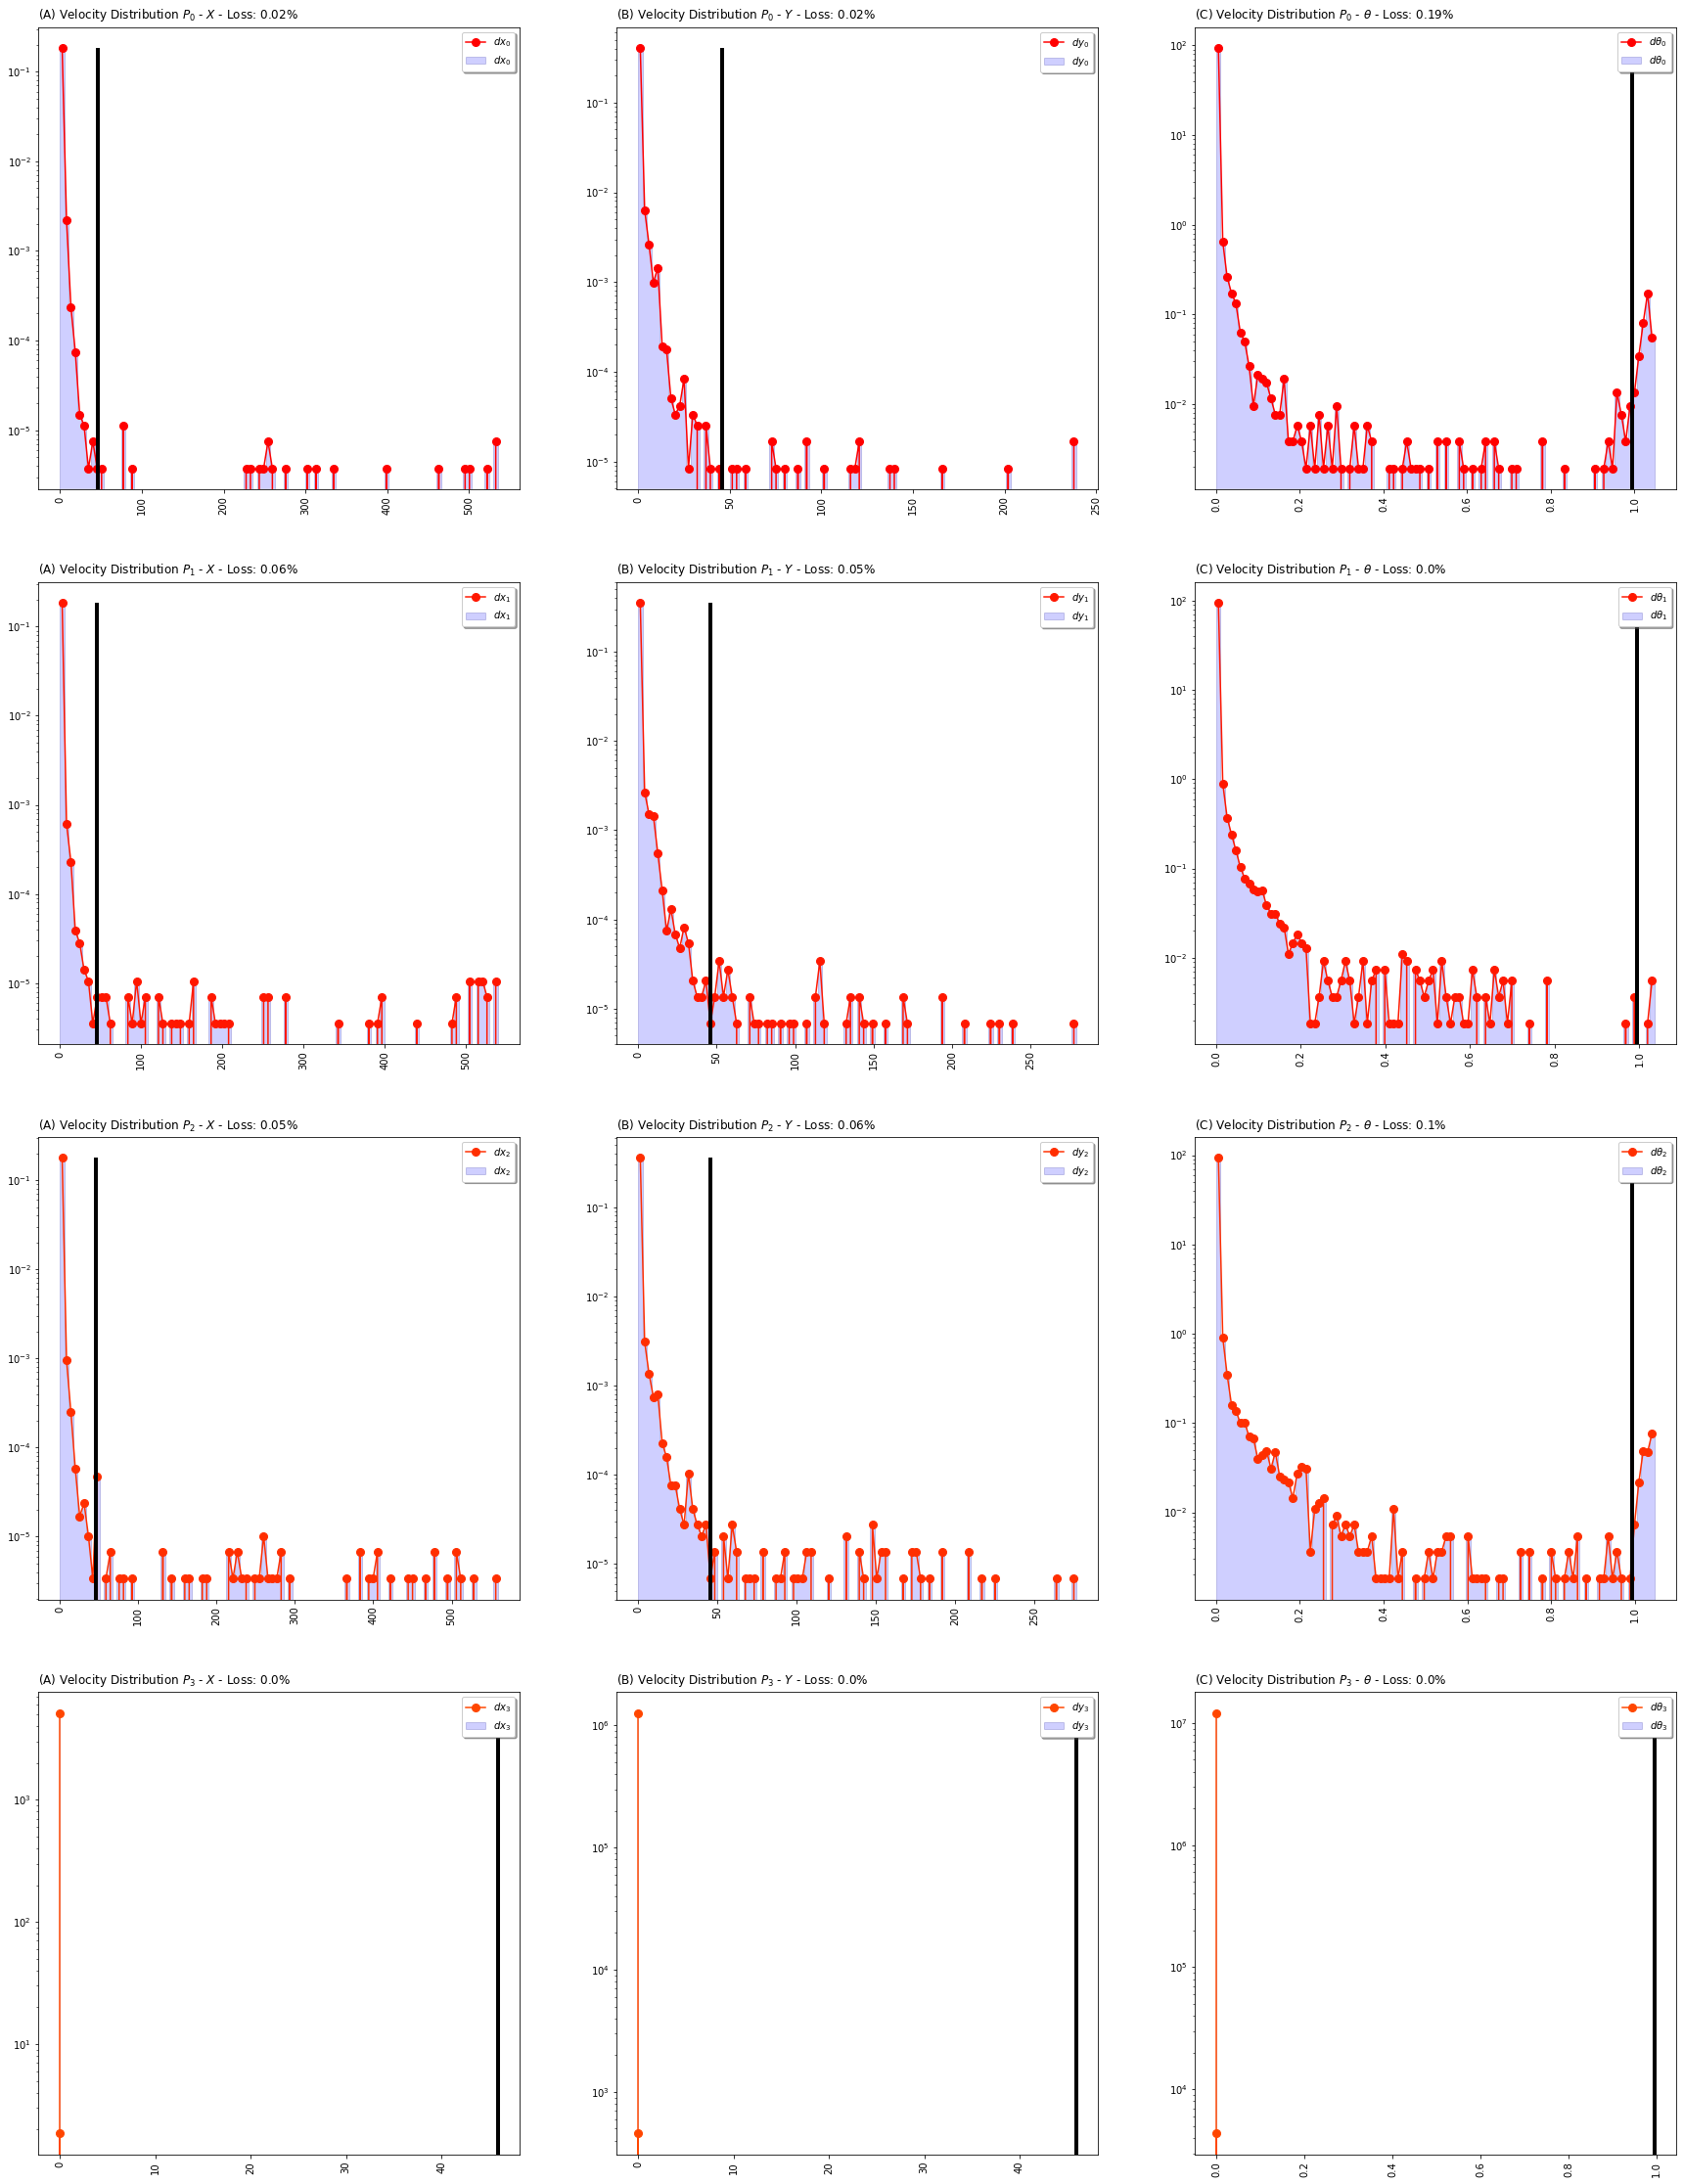

In [17]:
bins = 100
width = 10
fancy_legend = True
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

plt_cp.plot_velocities_distribution(
    df_tracked=df_filter_clustered,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [18]:
if "coords_x" in df_filter_clustered.columns:
    df_filter_clustered.drop(columns=["coords_x", "coords_y"]).to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)
else:
    df_filter_clustered.to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)

In [19]:
df_filter_clustered.head(n_particles * 3)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,0,0,1128.355016,135.134225,1129.559456,135.749677,NaN,1128.355016,135.134225,NaN,1128.355016,135.134225,1.339620,18402.0,261.256200,98.072387,0.926868,3,NaN,NaN,NaN,NaN,False,False,False
206,1,0,71.180153,236.658206,71.589759,237.546302,0.0,91.000000,168.000000,0.270588,85.000000,172.000000,0.287622,5240.0,140.177830,50.621343,0.932518,3,NaN,NaN,NaN,NaN,False,False,False
412,2,0,141.091814,444.704373,142.252499,446.915884,NaN,141.091814,444.704373,NaN,141.091814,444.704373,-0.349721,7134.0,164.611834,61.709658,0.927073,3,NaN,NaN,NaN,NaN,False,False,False
618,0,3,1129.018491,135.522993,1130.406676,136.268184,NaN,1129.018491,135.522993,NaN,1129.018491,135.522993,1.338298,18658.0,261.552924,98.271022,0.926733,3,3.0,0.221158,0.129589,-0.000441,False,False,False
619,1,3,71.136320,236.858151,71.556399,237.765684,0.0,81.000000,169.000000,0.262745,90.000000,172.000000,-0.286899,5245.0,139.971936,50.771906,0.931895,3,3.0,-0.014611,0.066648,-0.191507,False,False,False
620,2,3,141.033872,444.308222,142.180944,446.076880,NaN,141.033872,444.308222,NaN,141.033872,444.308222,-0.361507,7115.0,163.056815,60.909388,0.927611,3,3.0,-0.019314,-0.132050,-0.003929,False,False,False
621,0,6,1129.077903,135.588657,1130.470554,136.354796,NaN,1129.077903,135.588657,NaN,1129.077903,135.588657,1.338226,18690.0,261.570746,98.320204,0.926667,3,3.0,0.019804,0.021888,-0.000024,False,False,False
622,1,6,71.132445,236.896670,71.554051,237.789013,0.0,81.000000,169.000000,0.262745,93.000000,172.000000,-0.287353,5255.0,139.821108,50.822937,0.931600,3,3.0,-0.001292,0.012840,-0.000151,False,False,False
623,2,6,141.026013,443.880313,142.212840,445.322484,NaN,141.026013,443.880313,NaN,141.026013,443.880313,-0.361023,7035.0,163.526834,61.187357,0.927359,3,3.0,-0.002620,-0.142636,0.000161,False,False,False


## Visualize final data

In [20]:
width = 10
n_x_breaks = 20
n_y_breaks = 20
x_bounds = x_bounds  # Range: [0, 1080]
y_bounds = y_bounds  # Range: [0, 1920]
x_zoom = None  # x_zoom
y_zoom = None  # y_zoom
fancy_legend = True
x_legend = 1.001
y_legend = 0.821

if save_figures:
    df_data = df_filter_clustered[["time", "id_count", "id"]].drop_duplicates()
    df_data["id_included"] = True
    df_data["orientation_included"] = True

    # for time in tqdm(df_filter_clustered["time"].unique()):
    for time in tqdm([0, 10, 20, 50, 100]):
        plt_tp.plot_tracking_frame(
            reader=reader,
            df_tracked_frame=df_filter_clustered,
            width=width,
            n_x_breaks=n_x_breaks,
            n_y_breaks=n_y_breaks,
            x_bounds=x_bounds,
            y_bounds=y_bounds,
            x_zoom=x_zoom,
            y_zoom=y_zoom,
            fancy_legend=fancy_legend,
            x_legend=x_legend,
            y_legend=y_legend,
            save_figure=True,
            output_path=output_path,
            output_name="{}_c".format(video_name),
            time=time
        )

    df_data.to_csv("{}/{}_c/df_control.csv".format(output_path, video_name), index=False)


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


In [21]:
from shutil import make_archive

make_archive(
    "{}/{}_c".format(output_path, video_name),
    "zip",
    output_path,
    "{}/{}_c".format(output_path, video_name)
)

'/home/fabril/Github/High_Order_Interactions/tracking_videos/output_files/3n_3m_0f_240214_4_c.zip'